In [2]:
from select import select
from certifi import where
from odps import ODPS
from odps import options
from odps.df import DataFrame
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

In [3]:

ACCESS_ID = 'LTAI5tMuyirvXSdReNRh2xBK'
SECRET_ACCESS_KEY = 'z9fsKUFRGmx3oS7qTcSARc6E5CoMkU'
ODPS_PROJECT = 'OpenDigger_prod_dev'
ODPS_ENDPOINT = 'http://service.cn-shanghai.maxcompute.aliyun.com/api'
# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY,
         project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

github_log = DataFrame(o.get_table('ods_github_log'))
# print(github_log.dtypes)
repo = github_log.query("repo_name = 'apache/incubator-weex' and pt>'20150101'")
repo_df = repo.to_pandas()


In [5]:
# 时间处理
repo_df['time'] = pd.to_datetime(repo_df['created_at'],format='%Y-%m-%d %H:%M:%S')
repo_df['year'] = repo_df['time'].dt.year
repo_df['month'] = repo_df['time'].dt.month
repo_df['month'] = repo_df['month'].map("{:02}".format)
repo_df['ym'] = repo_df['year'].astype(str).str.cat(repo_df['month'].astype(str))
# repo_df.to_csv("./data/incubator-weex.csv")

<Figure size 2160x576 with 0 Axes>

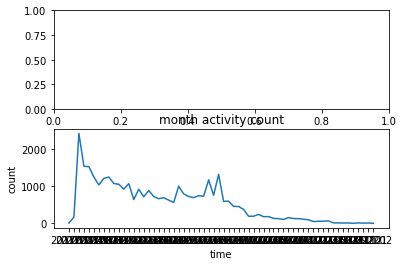

In [6]:
# 每月活跃事件数量
data = repo_df.groupby("ym").agg('count')['id']
plt.figure(figsize=(30,8))
# fig, axs = plt.subplots(2, 1)
plt.title("month activity count") 
plt.xlabel("time") 
plt.ylabel("count") 
plt.plot(data.index,data) 
plt.show()
# data.index

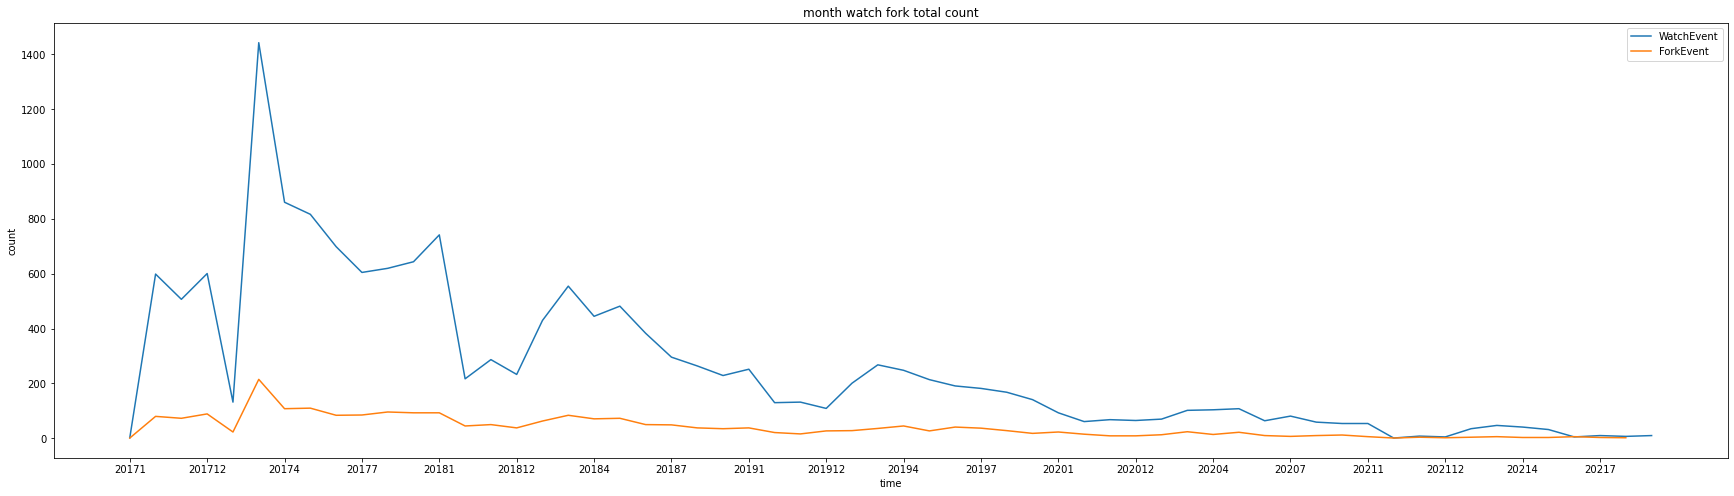

In [60]:
# 每月新增 Star 和 Frok 的个数
data5 = repo_df[repo_df.type == 'WatchEvent']
data5 = data5.groupby("ym").agg('count')['id']
data5_diff = data5.diff()
data6 = repo_df[repo_df.type == 'ForkEvent']
data6 = data6.groupby("ym").agg('count')['id']
data6_diff = data6.diff()


# 每月新增数据
plt.figure(figsize=(30,8))
plt.xticks(np.arange(0, data5.size, step=3))
plt.title("month watch fork total count") 
plt.xlabel("time") 
plt.ylabel("count") 
plt.plot(data5.index,data5, color='tab:blue', label='WatchEvent') 
plt.plot(data6.index,data6, color='tab:orange', label='ForkEvent')
plt.legend() 
plt.show()


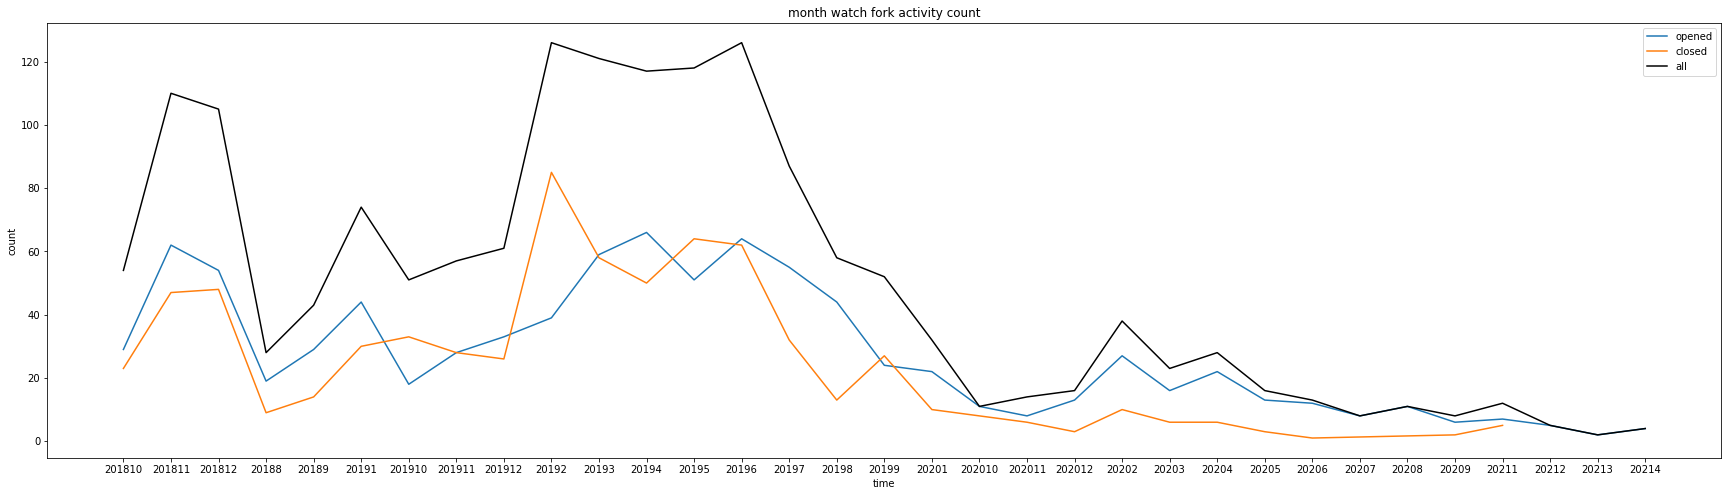

In [65]:
# 每月打开 Issue 和 关闭 Issue 的个数
data7 = repo_df[(repo_df.type == 'IssuesEvent') & (repo_df.action == 'opened')]
data7 = data7.groupby("ym").agg('count')['id']
data8 = repo_df[(repo_df.type == 'IssuesEvent') & (repo_df.action=='closed')]
data8 = data8.groupby("ym").agg('count')['id']
data9 = repo_df[(repo_df.type == 'IssuesEvent')]
data9 = data9.groupby("ym").agg('count')['id']
plt.figure(figsize=(30,8))
plt.title("month watch fork activity count") 
plt.xlabel("time") 
plt.ylabel("count") 
plt.plot(data7.index,data7, color='tab:blue', label='opened') 
plt.plot(data8.index,data8, color='tab:orange', label='closed') 
plt.plot(data9.index,data9, color='k', label='all') 
plt.legend()
plt.show()

In [122]:
# 每月在仓库中活跃（只要有日志产生就算）的不同开发者（也就是一个GitHub账号）总数
sql = """
    set odps.sql.validate.orderby.limit=false;
    select count(distinct(actor_id)) as count ,pt from ods_github_log where pt>'0' and repo_name='apache/incubator-weex' group by pt order by pt;
"""
with o.execute_sql(sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader4:
    # print(reader4.raw)
    # data2 = reader4.raw
    list = []
    for record in reader4:
        list.append([record["count"], record["pt"]])
        # print(record["count"],record["pt"])

No handles with labels found to put in legend.


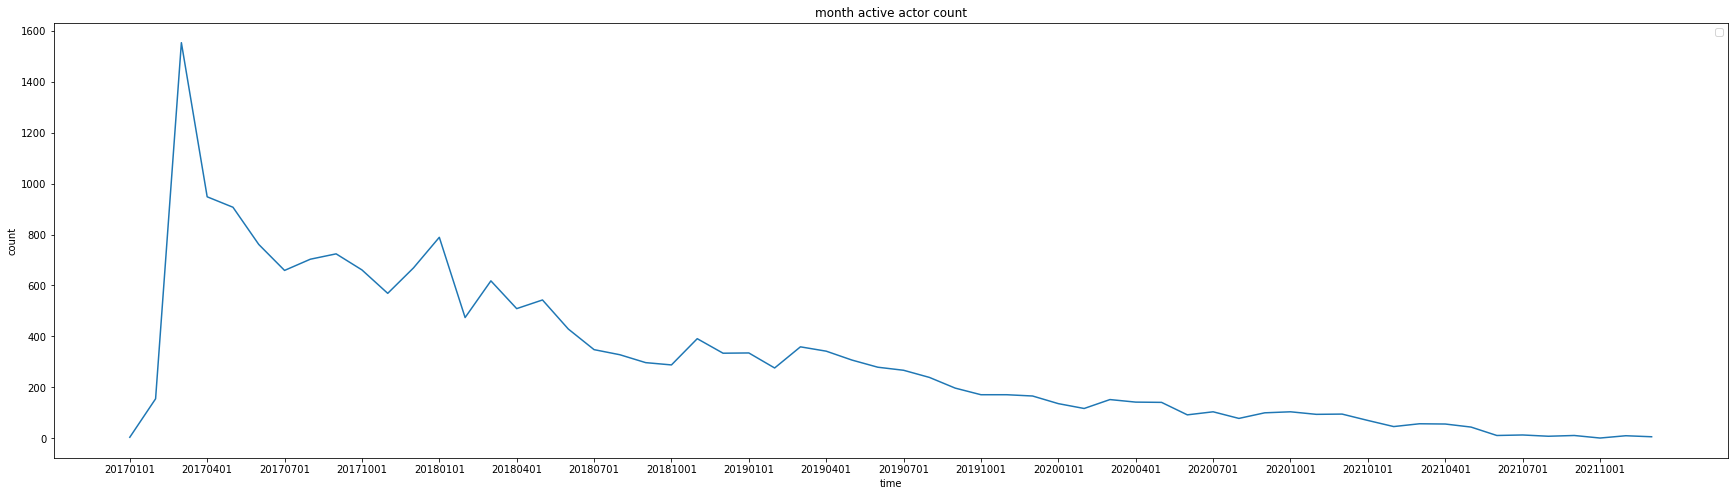

In [123]:
data2 = pd.DataFrame(list)
plt.figure(figsize=(30,8))
plt.xticks(np.arange(0, data5.size, step=3))
plt.title("month active actor count") 
plt.xlabel("time") 
plt.ylabel("count") 
plt.plot(data2[1],data2[0]) 
plt.legend()
plt.show()

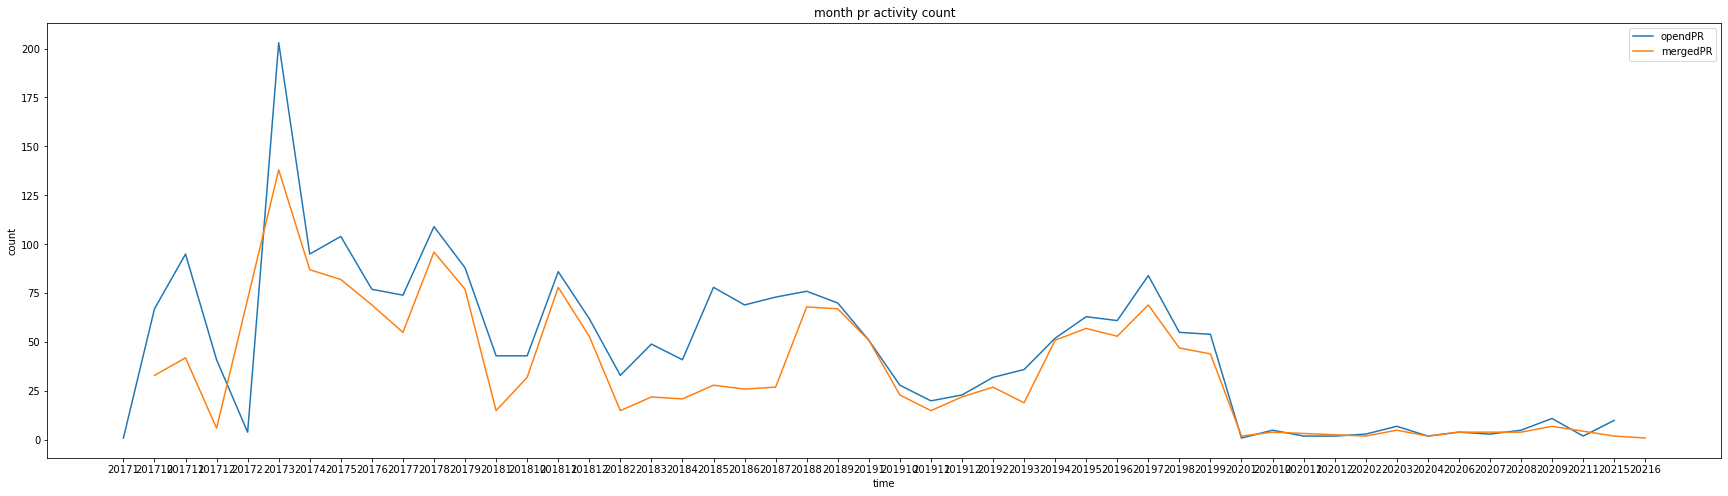

In [97]:
# 每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）
data3 = repo_df[(repo_df.type == 'PullRequestEvent') & (repo_df.action == 'opened')]
data3 = data3.groupby("ym").agg('count')['id']
data4 = repo_df[(repo_df.type == 'PullRequestEvent') & (repo_df.pull_merged == 1)]
data4 = data4.groupby("ym").agg('count')['id']
plt.figure(figsize=(30,8))
plt.title("month pr activity count") 
plt.xlabel("time") 
plt.ylabel("count") 
plt.plot(data3.index,data3, color='tab:blue', label='opendPR') 
plt.plot(data4.index,data4, color='tab:orange', label='mergedPR') 
plt.legend()
plt.show()


In [98]:
# Issue 从打开到关闭的平均时长和中位数（单位：天）
sql = """
    set odps.sql.validate.orderby.limit=false;
    select count(distinct(action)) as ac_count, datediff(max(created_at), min(created_at), 'dd') as diff_time from ods_github_log where pt>'0' and repo_name='apache/incubator-weex' and type='IssuesEvent' and action != '' group by issue_number having ac_count >= 2;
"""
with o.execute_sql(sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader4:
    # print(reader4.raw)
    # data2 = reader4.raw
    list = []
    for record in reader4:
        list.append([record["ac_count"], record["diff_time"]])
        # print(record["count"],record["pt"])

In [99]:
data9 = pd.DataFrame(list)
# 
print("Issue 从打开到关闭的平均时长:{}天\nIssue 从打开到关闭的中位数:{}天".format(data9.mean()[1], data9.median()[1]))

Issue 从打开到关闭的平均时长:21.652713178294572天
Issue 从打开到关闭的中位数:5.0天


In [103]:
# PR 从打开到合入的平均时长和中位数（单位：天）
sql = """
    set odps.sql.validate.orderby.limit=false;
    select count(distinct(action)) as ac_count, datediff(max(created_at), min(created_at), 'dd') as diff_time from ods_github_log where pt>'0' and repo_name='apache/incubator-weex' and type='PullRequestEvent' and action != '' group by issue_number having ac_count >= 2;
"""
with o.execute_sql(sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader4:
    # print(reader4.raw)
    # data2 = reader4.raw
    list = []
    for record in reader4:
        list.append([record["ac_count"], record["diff_time"]])
        # print(record["count"],record["pt"])

In [109]:
data10 = pd.DataFrame(list)
# data10
print("PR 从打开到合入的平均时长:{}天\nPR 从打开到合入的中位数:{}天(0天代表24小时之内)".format(data10.mean()[1], data10.median()[1]))

PR 从打开到合入的平均时长:10.572911963882618天
PR 从打开到合入的中位数:0.0天


In [132]:
# Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）
sql = """
    set odps.sql.validate.orderby.limit=false;
    select 
        datediff(min(issue_comment_created_at), min(issue_created_at), 'dd') as diff_time 
        from ods_github_log 
        where pt>'0' 
        and repo_name='apache/incubator-weex' 
        and (type='IssueCommentEvent' 
        or type='PullRequestEvent')
        and issue_comment_author_id != issue_author_id
        group by issue_number;
"""
list = []
with o.execute_sql(sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}).open_reader() as reader4:
    # print(reader4.raw)
    # data2 = reader4.raw
    for record in reader4:
        list.append(record["diff_time"])
        # print(record["count"],record["pt"])

In [134]:
data11 = pd.DataFrame(list)
print("Issue和PR从打开到第一次有人回复（非本人回复）的平均时长:{}\nIssue和PR从打开到第一次有人回复（非本人回复）的中位数:{}".format(data11.mean()[0], data11.median()[0]))

Issue和PR从打开到第一次有人回复（非本人回复）的平均时长:4.869785999274574
Issue和PR从打开到第一次有人回复（非本人回复）的中位数:0.0


# 根据你观察到的仓库的历史数据，尝试找到几个你认为关键或值得注意的时间节点
首先2017年3月份pr数量最高代码合入最多，最后一次增长的阶段是2019年7月。2019年7月之后整个项目进入消亡阶段，不怎么活跃了.
而且2017年3月份活跃的人员流入的最多，说明2017年3月份出现特殊事件。
项目2017年创建并且有活跃事件，但是到2018年10月才开放issue事件，说明2017年1月份到2018年10月份期间是内部协作沟通，没有外部讨论贡献.
2017年-2020年整体成具有波谷间隙，说明产出具有一定的周期性。
2017年2月很少的PR事件，说明2017年2月出现一定的异常事件。

